In [1]:
import astropy
from astropy.io import fits
from astropy import units as u

import numpy as np
import matplotlib.pyplot as plt

import sherpa
import sherpa.astro.ui as ui
from sherpa.models.basic import Gauss1D, PowLaw1D
from sherpa.models import PowLaw1D
from sherpa.data import Data1D
from sherpa.plot import DataPlot, ModelPlot, FitPlot
from sherpa.stats import LeastSq
from sherpa.optmethods import LevMar, NelderMead
from sherpa.fit import Fit

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
hdul = fits.open("assets/binary_table.fits")
hdul.info()

Filename: assets/binary_table.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     15   200R x 3C   [D, D, D]   


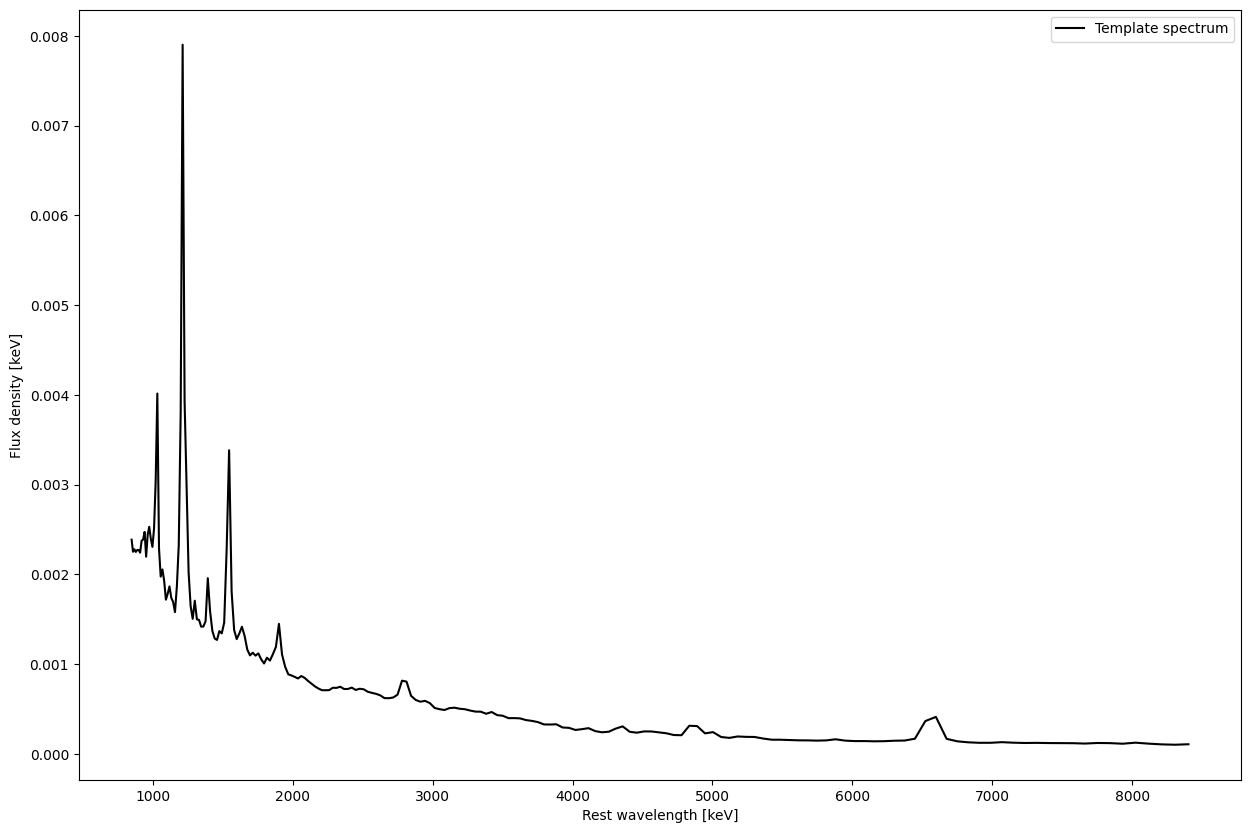

In [3]:
#save as array
binary_table = hdul[1]

data = binary_table.data
wave_arr = np.array(data['Wavelength'])
keV_arr = np.array(data['Energy: keV'])
flambda_arr = np.array(data['Flambda'])

fig1 = plt.figure(figsize=(15,10))
plt.xlabel('Rest wavelength [keV]')
plt.ylabel('Flux density [keV]')
plt.plot(wave_arr, flambda_arr, color='k', ls='-', label='Template spectrum')
plt.legend(loc='best')
plt.show()


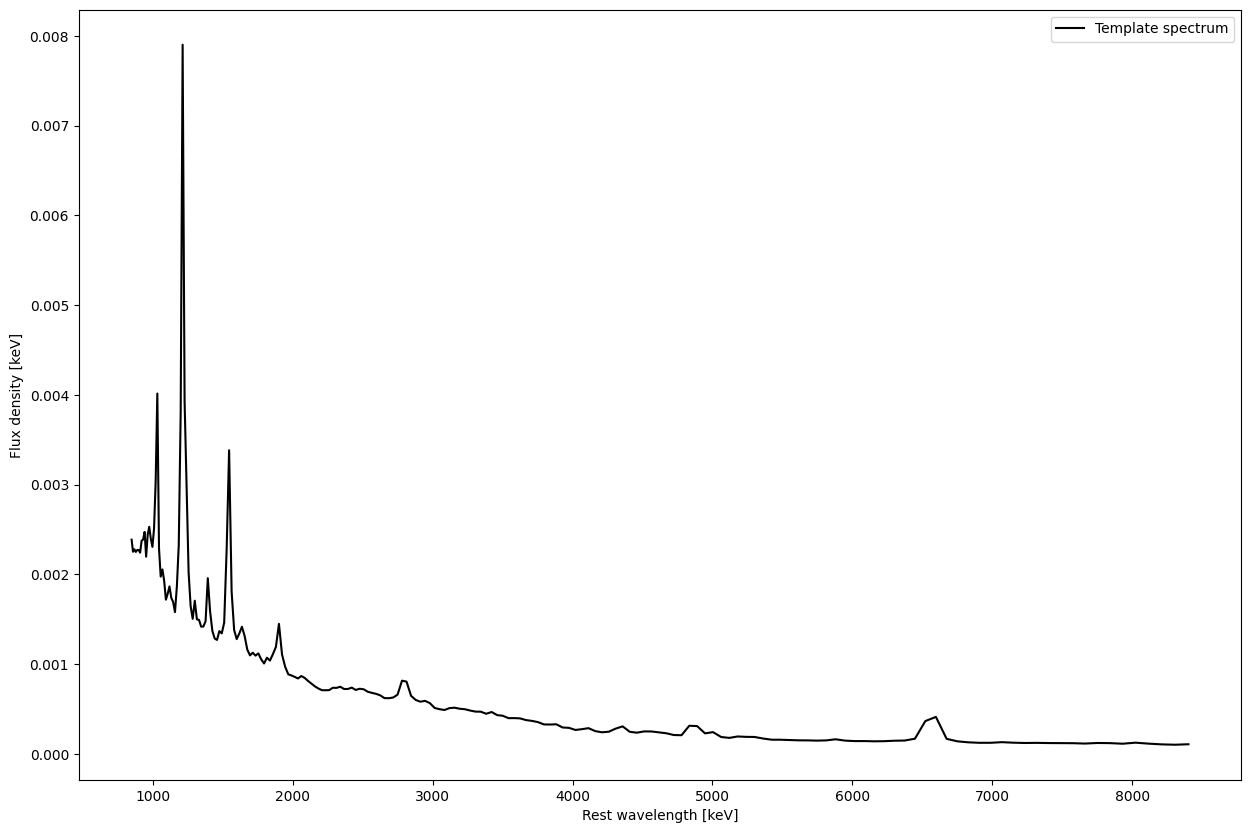

Spectrum Data Object:
name      = Data and Model (Not Best Fit)
x         = Float64[200]
y         = Float64[200]
staterror = None
syserror  = None


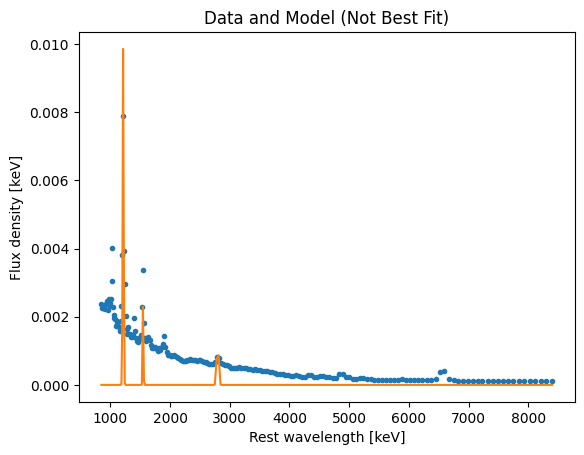

Model Object: 
data      = Data and Model (Not Best Fit)
model     = (((gauss1d + gauss1d) + gauss1d) + powlaw1d)
stat      = LeastSq
method    = LevMar
estmethod = Covariance
Model Result:  True


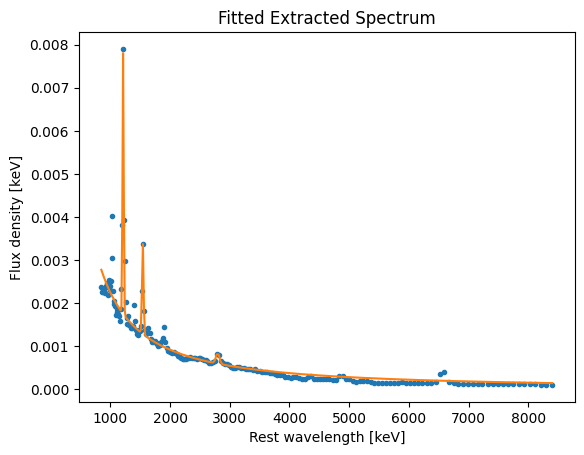

Parameters (after best fit):
('gauss1d.fwhm', 'gauss1d.pos', 'gauss1d.ampl', 'gauss1d.fwhm', 'gauss1d.pos', 'gauss1d.ampl', 'gauss1d.fwhm', 'gauss1d.pos', 'gauss1d.ampl', 'powlaw1d.gamma', 'powlaw1d.ampl')
(23.574389002634156, 1214.7408167813498, 0.006059733664551817, 67.54012784093855, 2798.8270298217144, 0.0002504014281387788, 29.284793797659812, 1544.0706032434446, 0.0021285590172658688, 1.29189831812065, 16.891874644810404)


In [7]:

#create the AGN model - consists of powerlaw and gaussian lines
#note that the AGN model is defined in units of wavelengths (angstroms)
#later we will define the AGN model in keV to match our ARF and RMF files

#create the power law continuum model
#set initial photon index of power law to 2
powerlaw = PowLaw1D()
powerlaw.gamma = 2.0

#create the Gaussian line models
#lyman alpha emission line taken at rest wavelength
lyman_alpha = Gauss1D()
lyman_alpha.pos = 1215.67       #Lyman alpha position
lyman_alpha.ampl = 100/10000    #Lyman alpha amplitude
lyman_alpha.fwhm = 19.46        #Lyman alpha FWHM

#Mg[II] emission line taken at rest wavelength
mg_ii = Gauss1D()
mg_ii.pos = 2798.75             #Magnesium II position
mg_ii.ampl = 14.725/10000       #Magnesium II amplitude
mg_ii.fwhm = 34.95              #Magnesium II FWHM

#C[IV] emission line taken at rest wavelength
c_iv = Gauss1D()
c_iv.pos = 1549.06             #Carbon IV position
c_iv.ampl = 25.291/10000       #Carbon IV amplitude
c_iv.fwhm = 14.33              #Carbon IV FWHM

#define the model 
#final model contains all emission lines present in AGN source 
#emission lines are added to the powerlaw
model = lyman_alpha + mg_ii + c_iv + powerlaw

#load template spectrum
template_spectrum_path = "assets/shang_etal_2011_figure6_flambdaunits.dat"

#first column is the wavelength
#second column is the flux
wave = np.loadtxt(template_spectrum_path, skiprows=1, usecols=0)  ## wavelength [Angstrom] or [A]
flambda = np.loadtxt(template_spectrum_path, skiprows=1, usecols=1)  ## flux density [erg/s/cm^2/A]

#plot the data - template spectrum 
fig1 = plt.figure(figsize=(15,10))
plt.xlabel('Rest wavelength [keV]')
plt.ylabel('Flux density [keV]')
plt.plot(wave, flambda, color='k', ls='-', label='Template spectrum')
plt.legend(loc='best')
plt.show()

#create a data object that pertains to the above template spectrum
data = Data1D('Data and Model (Not Best Fit)', wave_arr, flambda_arr)
print("Spectrum Data Object:")
print(data)

#create data plot
dplot = DataPlot()
dplot.prepare(data)

#create model plot
mplot = ModelPlot()
mplot.prepare(data, model)

#plot model and data on same graph
dplot.plot()
mplot.overplot()
plt.xlabel('Rest wavelength [keV]')
plt.ylabel('Flux density [keV]')
plt.title('Data and Model (Not Best Fit)')
plt.show()

#least-square statistic is used
stat = LeastSq()
#optimiser is the part that determines how to minimise the statistic value
#Levenberg-Marquardt (LevMar) is used
opt = LevMar()

#fit the data using the chosen statistic and optimizer method
#best fit of the data set is determined when the least square stat is minimized 
modelfit = Fit(data, model, stat=stat, method=opt)
print("Model Object: ")
print(modelfit)
modelres = modelfit.fit()
print("Model Result: ", modelres.succeeded)

#plot the fit 
fplot = FitPlot()
mplot.prepare(data, model)
fplot.prepare(dplot, mplot)
fplot.plot()
plt.xlabel('Rest wavelength [keV]')
plt.ylabel('Flux density [keV]')
plt.title("Fitted Extracted Spectrum")
plt.show()

#print the fitted parameters and values
print("Parameters (after best fit):")
print(modelres.parnames)
print(modelres.parvals)

Model Object: 
data      = Data and Model (Not Best Fit)
model     = (((gauss1d + gauss1d) + gauss1d) + powlaw1d)
stat      = LeastSq
method    = LevMar
estmethod = Covariance
Model Result:  True


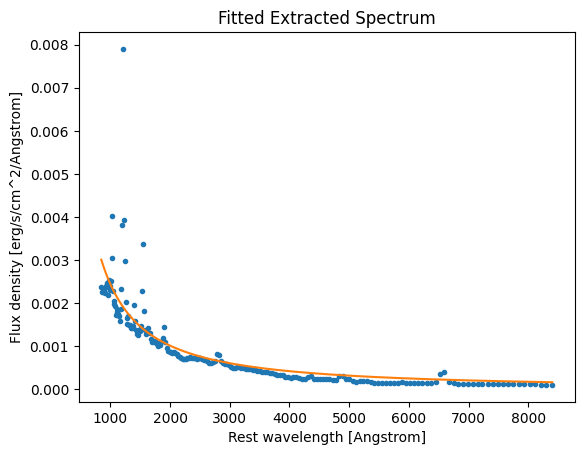

In [15]:
#model stuff

#create the power law continuum model
#set initial photon index of power law to 2
powerlaw = PowLaw1D()
powerlaw.gamma = -1.5

#rest wavelengths of gaussian line models (nm)
#need to convert to keV as ARF and RMF are in keV
lyman_wave = 121.567    
lyman_eV = (lyman_wave * u.nm).to(u.eV, equivalencies=u.spectral())
lyman_keV = (lyman_eV.value)/1000
 
mg_wave = 279.875
mg_eV = (mg_wave * u.nm).to(u.eV, equivalencies=u.spectral())
mg_keV = (mg_eV.value)/1000
 
c_wave = 154.906
c_eV = (c_wave * u.nm).to(u.eV, equivalencies=u.spectral())
c_keV = (c_eV.value)/1000
 
#create the Gaussian line models
#lyman alpha emission line taken at rest wavelength
#relative amplitudes are taken from Vandeberk
lyman_alpha = Gauss1D()
lyman_alpha.pos = lyman_keV         #Lyman alpha position (keV)
lyman_alpha.ampl = 100/10000        #Lyman alpha amplitude
lyman_alpha.fwhm = 19.46/100000     #Lyman alpha FWHM

#Mg[II] emission line taken at rest wavelength
mg_ii = Gauss1D()
mg_ii.pos = mg_keV                 #Magnesium II position (keV)
mg_ii.ampl = 14.725/10000          #Magnesium II amplitude
mg_ii.fwhm = 34.95/100000          #Magnesium II FWHM

#C[IV] emission line taken at rest wavelength
c_iv = Gauss1D()
c_iv.pos = c_keV                   #Carbon IV position (keV)
c_iv.ampl = 25.291/10000           #Carbon IV amplitude 
c_iv.fwhm = 14.33/100000           #Carbon IV FWHM

#define the model 
#final model contains all emission lines present in AGN source 
#emission lines are added to the powerlaw
model = lyman_alpha + mg_ii + c_iv + powerlaw
ui.plot_model(overplot = True)

#fit the data using the chosen statistic and optimizer method
#best fit of the data set is determined when the least square stat is minimized 
modelfit = Fit(data, model, stat=stat, method=opt)
print("Model Object: ")
print(modelfit)
modelres = modelfit.fit()
print("Model Result: ", modelres.succeeded)

#plot the fit 
fplot = FitPlot()
mplot.prepare(data, model)
fplot.prepare(dplot, mplot)
fplot.plot()
plt.xlabel('Rest wavelength [Angstrom]')
plt.ylabel('Flux density [erg/s/cm^2/Angstrom]')
plt.title("Fitted Extracted Spectrum")
plt.show()

In [18]:
load_arr = ui.load_arrays('flambda_keV',keV_arr, flambda_arr)
flambda_keV = ui.get_data('flambda_keV')
print("dataset info: ")
print(flambda_keV)
ui.set_model(id = model, model = None)
ui.set_data(load_arr, ui.get_data('flambda_keV'))
fake_spectra = ui.fake()

dataset info: 
name      = 
x         = Float64[200]
y         = Float64[200]
staterror = None
syserror  = None


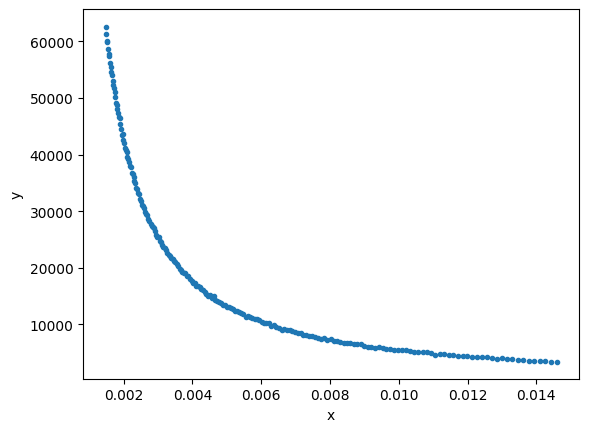

In [19]:
ui.plot_data()